In [2]:
import tensorflow_datasets as tfds

In [3]:
imdb, info = tfds.load('imdb_reviews', with_info = True, as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBPDJQ4/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBPDJQ4/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBPDJQ4/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [20]:
import numpy as np
train_sentences = []
test_sentences = []
train_labels = []
test_labels = []

for s, l in imdb['train']:
    train_sentences.append(s.numpy().decode('utf8'))
    train_labels.append(l)
for s,l in imdb['test']:
    test_sentences.append(s.numpy().decode('utf8'))
    test_labels.append(l)
    
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [21]:
vocab_size = 10000
oov_token = '<oov>'
embedding_dim = 16
max_length = 120
padding = 'post'
gru_dim = 64
dense_dim = 64

In [22]:
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(train_sentences)
padded_train_sequence = pad_sequences(train_sequences,maxlen=max_length, padding=padding)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
padded_test_sequence = pad_sequences(test_sequences,maxlen=max_length, padding=padding)

In [23]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim),
    keras.layers.Bidirectional(keras.layers.GRU(gru_dim, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.GRU(gru_dim)),
    keras.layers.Dense(dense_dim, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
history = model.fit(padded_train_sequence, train_labels, epochs=10, validation_data=(padded_test_sequence, test_labels))

Epoch 1/10
782/782 [==============================] - 148s 190ms/step - loss: 0.0131 - accuracy: 0.9956 - val_loss: 0.9494 - val_accuracy: 0.8292
Epoch 2/10
782/782 [==============================] - 148s 189ms/step - loss: 0.0130 - accuracy: 0.9956 - val_loss: 1.2545 - val_accuracy: 0.8283
Epoch 3/10
782/782 [==============================] - 147s 188ms/step - loss: 0.0105 - accuracy: 0.9962 - val_loss: 1.1764 - val_accuracy: 0.8134
Epoch 4/10
782/782 [==============================] - 148s 189ms/step - loss: 0.0105 - accuracy: 0.9964 - val_loss: 1.1236 - val_accuracy: 0.8360
Epoch 5/10
782/782 [==============================] - 148s 190ms/step - loss: 0.0067 - accuracy: 0.9977 - val_loss: 1.1107 - val_accuracy: 0.8332
Epoch 6/10
782/782 [==============================] - 149s 190ms/step - loss: 0.0071 - accuracy: 0.9976 - val_loss: 1.3191 - val_accuracy: 0.8363
Epoch 7/10
782/782 [==============================] - 149s 190ms/step - loss: 0.0080 - accuracy: 0.9970 - val_loss: 1.1920 -

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = history.epoch

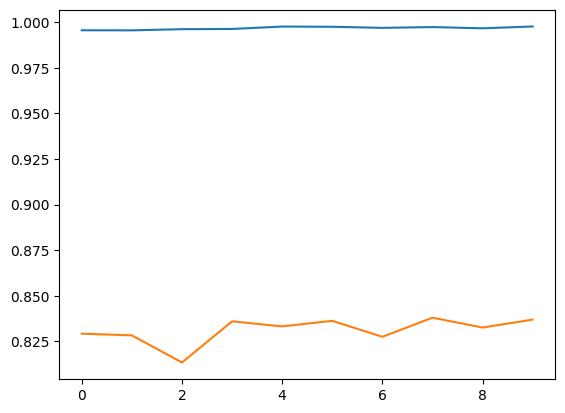

In [30]:
import matplotlib.pyplot as plt
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)

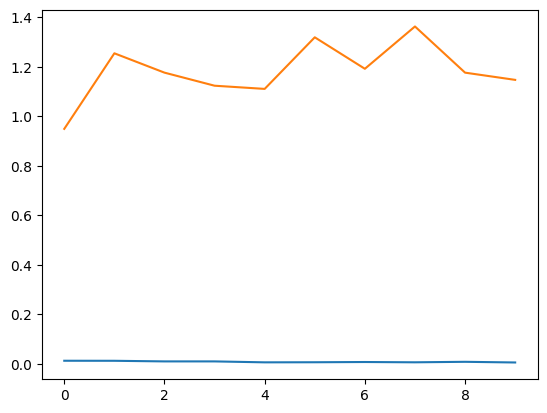

In [31]:
plt.plot(epochs,loss)
plt.plot(epochs, val_loss)

In [32]:
embedding_layer = model.layers[0]

In [46]:
embedding_weights = embedding_layer.get_weights()[0]

In [47]:
reverse_index = tokenizer.index_word

In [48]:
import io

out_v = io.open('vecs.tsv','w',encoding='utf8')
out_m = io.open('meta.tsv','w',encoding='utf8')

for word_num in range(1,vocab_size):
    word = reverse_index[word_num]
    out_m.write(word+"\n")
    
    embedding = embedding_weights[word_num]
    out_v.write("\t".join(str(s) for s in embedding)+"\n")
    
out_v.close()
out_m.close()